# CLASSIFICADOR SENZILL FINDING - NO FINDING

## 1. Importem llibraries

In [1]:
!pip -q install torchsummary

In [2]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
import shutil

## 2. Fem una mica de EDA

In [3]:
train_csv_path = '/kaggle/input/amia-public-challenge-2024/train.csv'
img_size_csv_path = '/kaggle/input/amia-public-challenge-2024/img_size.csv'
test_csv_path = '/kaggle/input/amia-public-challenge-2024/test.csv'
train_img_dir = '/kaggle/input/amia-public-challenge-2024/train/train'

In [4]:
df = pd.read_csv(train_csv_path)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4,No finding,14,R13,NaN,NaN,NaN,NaN
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z,No finding,14,R5,NaN,NaN,NaN,NaN


In [5]:
df = df[['image_id', 'class_name']]
df['image_id'] = df['image_id'].astype(str) + '.png'
df.head()

,image_id,class_name
0,bM8C97htulC9fHKIDurJHquCXr1KZuug.png,No finding
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m.png,Aortic enlargement
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w.png,Consolidation
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4.png,No finding
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z.png,No finding


In [6]:
df[df.duplicated(keep=False)]

,image_id,class_name
0,bM8C97htulC9fHKIDurJHquCXr1KZuug.png,No finding
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m.png,Aortic enlargement
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4.png,No finding
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z.png,No finding
5,SfZftHo1WIammJ8tb4rBMSzDaTtWYNsM.png,Nodule/Mass
...,...,...
45919,ppn0MgTpDweW6L3NKwAwkNjyE3kwPy4W.png,No finding
45920,2nu3UdPqvAVfRRuLcdpWS7XNieBBlgSF.png,Pleural effusion
45922,WFG7bP8fltyd7Awrm3YXoYUO5X6UEzbb.png,Pleural effusion
45923,cwVcnee8qkxNdKnOEsKFHuduCWmqffXb.png,Aortic enlargement


In [7]:
df.class_name.value_counts()

class_name
No finding            15525
Aortic enlargement     5481
Pleural thickening     4308
Pulmonary fibrosis     4097
Cardiomegaly           4046
Nodule/Mass            2324
Pleural effusion       2190
Lung Opacity           2188
Other lesion           1945
Infiltration           1097
ILD                     904
Calcification           851
Consolidation           519
Atelectasis             255
Pneumothorax            195
Name: count, dtype: int64

In [8]:
df['class_name'] = df['class_name'].apply(lambda x: 'No finding' if x == 'No finding' else 'Finding')

In [9]:
train_df, val_df = train_test_split(df, stratify=df['class_name'], train_size=0.8, random_state=42)

train_df['image_name'] = train_img_dir + '/' + train_df['image_id'].astype(str)
val_df['image_name'] = train_img_dir + '/' + val_df['image_id'].astype(str)

train_df.to_csv('train_csv.csv', index=False, header=True)
val_df.to_csv('val_csv.csv', index=False, header=True)

## 3. Data transformations

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## 4. Custom Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_name = self.data_frame.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        label = self.data_frame.iloc[idx, 1]
        label = 0 if label == 'No finding' else 1  # Example encoding
        image_id = self.data_frame.iloc[idx, 0]  # Get the image_id

        if self.transform:
            image = self.transform(image)

        return image, label, image_id  # Return image_id

In [12]:
train_dataset = CustomDataset(csv_file='train_csv.csv', root_dir=train_img_dir, transform=data_transforms['train'])
val_dataset = CustomDataset(csv_file='val_csv.csv', root_dir=train_img_dir, transform=data_transforms['val'])

## 5. Weighted Random Sampler 

In [13]:
class_counts = train_df['class_name'].value_counts()
class_weights = 1. / class_counts
sample_weights = [class_weights[class_name] for class_name in train_df['class_name']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [15]:
model = models.vgg16(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.6MB/s] 


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)

In [18]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    start_epoch = 0
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded: start_epoch={start_epoch}")
    return model, optimizer, start_epoch

In [19]:
def move_checkpoint():
    input_checkpoint_path = '/kaggle/input/checkpoint/checkpoint.pth'
    if os.path.exists(input_checkpoint_path):
        print("Checkpoint file found. Moving to working directory...")
        shutil.copyfile(input_checkpoint_path, './checkpoint.pth')
        print("Checkpoint moved successfully.")
    else:
        print("No checkpoint found in /kaggle/input/checkpoint. Training from scratch.")

# Movem el fitxer de checkpoint (en el cas que existeixi)
move_checkpoint()

Checkpoint file found. Moving to working directory...
Checkpoint moved successfully.


In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def train_model_with_checkpoints(model, criterion, optimizer, scheduler, num_epochs=25, checkpoint_path='checkpoint.pth', save_every=1, start_epoch=0):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f'Epoch {epoch}/{start_epoch + num_epochs - 1}')
        print('-' * 10)

        # Cada època té una fase de train i de validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, image_ids in dataloaders[phase]: 
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Fem una deepcopy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train' and (epoch + 1) % save_every == 0:
                torch.save(model.state_dict(), checkpoint_path)

        if scheduler:
            scheduler.step()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Carreguem el weights del millor model
    model.load_state_dict(best_model_wts)
    return model

In [22]:
model, optimizer, start_epoch = load_checkpoint(model, optimizer)

Checkpoint loaded: start_epoch=14


In [23]:
model = train_model_with_checkpoints(
    model, 
    criterion, 
    optimizer, 
    exp_lr_scheduler, 
    num_epochs=1, 
    checkpoint_path='checkpoint.pth', 
    save_every=1, 
    start_epoch=start_epoch
)

Epoch 14/14
----------
train Loss: 0.6217 Acc: 0.7008
val Loss: 0.3855 Acc: 0.8392
Training complete in 300m 35s
Best val Acc: 0.8392


In [24]:
def evaluate_model(model, dataloader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    all_image_ids = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels, image_ids in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_image_ids.extend(image_ids)  # Collect image IDs
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return all_image_ids, all_labels, all_preds

In [25]:
# Evaluem el model
image_ids, val_labels, val_preds = evaluate_model(model, val_loader)

In [26]:
# Guardem els resultats

results = []
model.eval()
with torch.no_grad():
    for inputs, labels, image_ids in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect results
        for i in range(len(image_ids)):
            results.append({
                'image_id': image_ids[i],
                'true_label': labels[i].item(),
                'predicted_label': preds[i].item()
            })


In [27]:
# Els guardem en un fitxer csv
df_results = pd.DataFrame(results)
df_results.to_csv('results.csv', index=False)

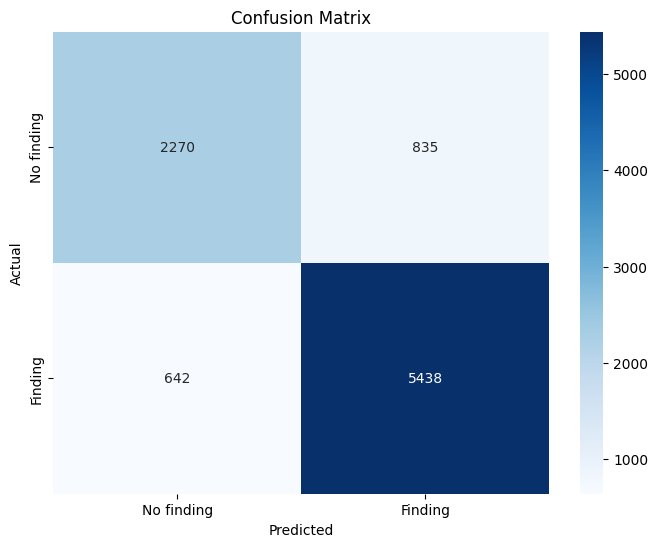

In [28]:
# Fem una matriu de confussió
cm = confusion_matrix(val_labels, val_preds)

# La mostrem
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No finding', 'Finding'], yticklabels=['No finding', 'Finding'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      3105
           1       0.87      0.89      0.88      6080

    accuracy                           0.84      9185
   macro avg       0.82      0.81      0.82      9185
weighted avg       0.84      0.84      0.84      9185



In [30]:
final_model_path = './final_model.pth'
torch.save(model.state_dict(), final_model_path)
print(f'Final model saved to {final_model_path}')

Final model saved to ./final_model.pth
